In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.manual_seed(42)

### Config Stuff

In [3]:
# model hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 5

In [4]:
class LayerConfig:
    def __init__(self, name, input_dim):
        self.name = name
        self.input_dim = input_dim

# Create instances for each layer
fc1_config = LayerConfig('fc1', 256)
fc2_config = LayerConfig('fc2', 128)
fc3_config = LayerConfig('fc3', 10)

### Load in Data

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from tqdm import tqdm

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalization for validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_name = 'EuroSAT'

# Load CIFAR10 dataset
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Load CIFAR100 dataset
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
# val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: Dataset not found. You can use download=True to download it

### Display the Image

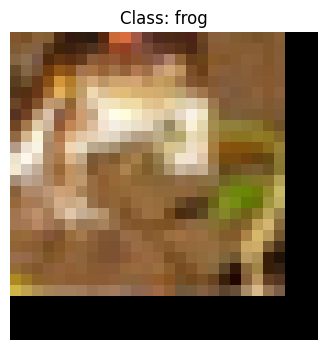

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Undo normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    # Convert to numpy and transpose from (C,H,W) to (H,W,C)
    img = img.numpy().transpose((1, 2, 0))
    
    # Unnormalize
    img = std * img + mean
    
    # Clip values to be between 0 and 1
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')

# Get a random image from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # Display a single image
# plt.figure(figsize=(4, 4))
# imshow(images[0])
# plt.title(f'Class: {labels[0].item()}')
# plt.show()

# If you want to display the actual class name
classes = train_dataset.classes  # Get class names
plt.figure(figsize=(4, 4))
imshow(images[0])
plt.title(f'Class: {classes[labels[0].item()]}')
plt.show()

In [7]:
from structs.models import MNISTModel, ColoredMNISTModel
# load in trained mnist model 
model = ColoredMNISTModel()
model.load_state_dict(torch.load('models/mnist_colored.pth'))

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_74447/2310615750.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/mnis

<All keys matched successfully>

### Get Activations

In [8]:
selected_layer_config = fc1_config

In [9]:
from tqdm import tqdm 
import matplotlib.pyplot as plt

model.clear_cache()
model.eval()
with torch.no_grad():
    for images, labels in tqdm(train_loader):
        outputs = model(images)

100%|██████████| 782/782 [00:15<00:00, 50.65it/s] 


In [10]:
num_images = len(train_loader.dataset)
print(f'Number of images in the train_loader: {num_images}')

Number of images in the train_loader: 50000


In [11]:
analysis_activations = model.get_cached_activations(selected_layer_config.name)
analysis_activations.shape

torch.Size([50000, 256])

In [12]:
torch.save(analysis_activations, f'embeddings/mnist_{selected_layer_config.name}_{data_name}.pth')

### Sae Analysis

In [13]:
from structs.models import SimpleSAE, EnhancedSAE

input_dim = selected_layer_config.input_dim
hidden_dim = 2304
sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)
sae.load_state_dict(torch.load('models/mnist_sae_colored.pth'))

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_74447/2399077495.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load('models/mnist_

<All keys matched successfully>

In [14]:
analysis_activations = torch.load(f'embeddings/mnist_{fc1_config.name}_{data_name}.pth')
analysis_loader = DataLoader(analysis_activations, batch_size=batch_size, shuffle=False) # do not shuffle

analysis_activations.shape

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_74447/1027644296.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  analysis_activations = torch.load(f'embedding

torch.Size([50000, 256])

In [15]:
# pass the activations through the SAE and save the intermediary activations 
sae.clear_cache()
sae.eval()
with torch.no_grad():
    for activations in tqdm(analysis_loader):
        encoded, decoded = sae(activations, cache_activations=True)

100%|██████████| 782/782 [00:00<00:00, 2064.36it/s]


In [16]:
sae_activations = sae.get_cached_activations('encoder')
torch.save(sae_activations, f'embeddings/mnist_encoder_{data_name}.pth')
sae_activations.shape

torch.Size([50000, 2304])

### Top 10 images

In [17]:
sae_activations = torch.load(f'embeddings/mnist_encoder_{data_name}.pth')

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_74447/2414796192.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_activations = torch.load(f'embeddings/mni

In [18]:
# transpose is to make it by neuron as opposed to by sample 
transposed = sae_activations.T
transposed.shape

torch.Size([2304, 50000])

In [19]:
max_10_indices_per_neuron = torch.argsort(transposed, descending=True, dim=1)[:, :10]
max_10_indices_per_neuron_value = torch.gather(transposed, 1, max_10_indices_per_neuron)

### Analyze Image

In [20]:
original_dataset = datasets.EuroSAT(root='./data', train=True, download=True, transform=None)

Files already downloaded and verified


In [21]:
def plot_indices_save(indices, filename, neuron_idx):
    plt.figure(figsize=(15, 4))  # Adjusted figure size for 10 images
    count = 0
    for i, idx in enumerate(indices):
        if transposed[neuron_idx][idx] == 0:
            # print('skipped idx', idx)
            continue
        count += 1


        img = train_dataset.data[idx]
        
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Index: {idx}')

    if plt.gca().has_data():
        plt.tight_layout()
        plt.savefig(f'docs/neuron_{data_name}/{count}_{filename}')  # Save the figure to a file
    plt.close()  # Close the figure to free memory

In [22]:
from tqdm import tqdm
import os 

os.makedirs(f'docs/neuron_{data_name}', exist_ok=True)

for i in tqdm(range(len(max_10_indices_per_neuron)), desc="Plotting neurons"):
    indices = max_10_indices_per_neuron[i]
    plot_indices_save(indices, f'neuron_{i}_plots.png', i)  # Save individual plots if needed


Plotting neurons: 100%|██████████| 2304/2304 [00:40<00:00, 57.51it/s]
